In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


In [ ]:
pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 1.8 MB/s eta 0:00:00


In [ ]:
pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 14.1 MB/s eta 0:00:00


In [ ]:
from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

from lightgbm import LGBMClassifier
import time

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
from keras_tuner import RandomSearch


# Data Preprocessing

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Thesis Code/transaction_dataset.csv").drop(columns=['Unnamed: 0'])
df.head(100)

,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,0x00da8417b2c53b1fac15fafddf9854285959e9b6,0,0.00,0.00,31.28,1,1,0,1,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
96,97,0x00df7c16597385f31dfc87d1e103eaab28fc0f8d,0,5.88,0.42,18.47,3,2,0,2,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
97,98,0x00e40876d147fdc499afa3f5a49cf6fe6256f196,0,21.65,0.00,64.95,3,1,0,1,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
98,99,0x00e87b69cf3686e028f96d14cd79ec30983e0f53,0,31239.32,984.92,251884.43,8,2,0,2,...,499.000000,5.000000e+03,3166.333333,0.0,0.0,0.0,1.0,8.0,Decentraland,XENON


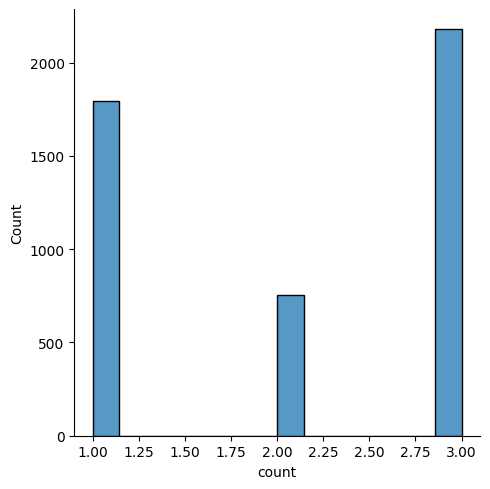

In [ ]:
sns.displot(df['Index'].value_counts())
plt.show()

In [ ]:
df_index_check = df.merge(
    df[['Index', 'Address']].groupby('Index').count().rename(columns={'Address': 'Index_count'}).reset_index(),
    on='Index'
)
df_index_check[df_index_check['Index_count'] > 1].head(10)

,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,...,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type,Index_count
0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,...,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire,3
1,1,0x4c13f6966dc24c92489344f0fd6f0e61f3489b84,0,5980.35,18633.46,498256.47,21,20,0,2,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,3
2,1,0x0020731604c882cf7bf8c444be97d17b19ea4316,1,1457.31,34.12,4815.43,3,13,0,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,...,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token,3
4,2,0x4c1da8781f6ca312bc11217b3f61e5dfdf428de1,0,7042.64,2694.86,80594.87,8,9,0,8,...,1.401027e+02,140.102687,0.0,0.0,0.0,1.0,2.0,Golem,OmiseGO,3
5,2,0x002bf459dc58584d58886169ea0e80f3ca95ffaf,1,3976.50,834.77,9622.53,2,2,0,1,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU,3
6,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON,3
7,3,0x4c24af967901ec87a6644eb1ef42b680f58e67f5,0,3098.05,4755.44,382590.08,36,57,0,2,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,3.0,NaN,VIU,3
8,3,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,1,112.90,31.87,321.42,2,3,0,3,...,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU,3
9,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,...,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON,3


In [ ]:
df.drop(columns=['Index']).drop_duplicates()

,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,118,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,14,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,2,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,13,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,19,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,0xff481ca14e6c16b79fc8ab299b4d2387ec8ecdd2,1,12635.10,631.39,58748.48,4,13,0,11,4,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,2.0,,GSENetwork
9837,0xff718805bb9199ebf024ab6acd333e603ad77c85,1,0.00,0.00,0.00,0,0,0,0,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU
9838,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,1,2499.44,2189.29,261601.88,67,43,0,31,44,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,5.0,,Free BOB Tokens - BobsRepair.com
9839,0xffde23396d57e10abf58bd929bb1e856c7718218,1,0.00,0.00,0.00,0,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.drop(columns=['Index']).drop_duplicates().shape[0]

9823

In [ ]:
df.shape[0]

9841

In [ ]:
# remove index

assert df.shape[0] == df.drop_duplicates().shape[0]
df = df.drop(columns='Index').drop_duplicates()

In [ ]:

zero_feature_list = df.columns[(df.nunique() == 1)].tolist()
zero_feature_list

[' ERC20 avg time between sent tnx',
 ' ERC20 avg time between rec tnx',
 ' ERC20 avg time between rec 2 tnx',
 ' ERC20 avg time between contract tnx',
 ' ERC20 min val sent contract',
 ' ERC20 max val sent contract',
 ' ERC20 avg val sent contract']

In [ ]:
# feature lists: all, numeric and categorical

feature_list = list(set(df.columns) - set(['Address', 'FLAG']) - set(zero_feature_list))
num_feature_list = list(set(feature_list) - set(df.dtypes[df.dtypes == 'object'].index)- set(zero_feature_list))
cat_feature_list = list(set(feature_list) - set(num_feature_list))

assert len(feature_list) == len(num_feature_list) + len(cat_feature_list)
print(len(feature_list))
print(len(num_feature_list))
print(len(cat_feature_list))

40
38
2


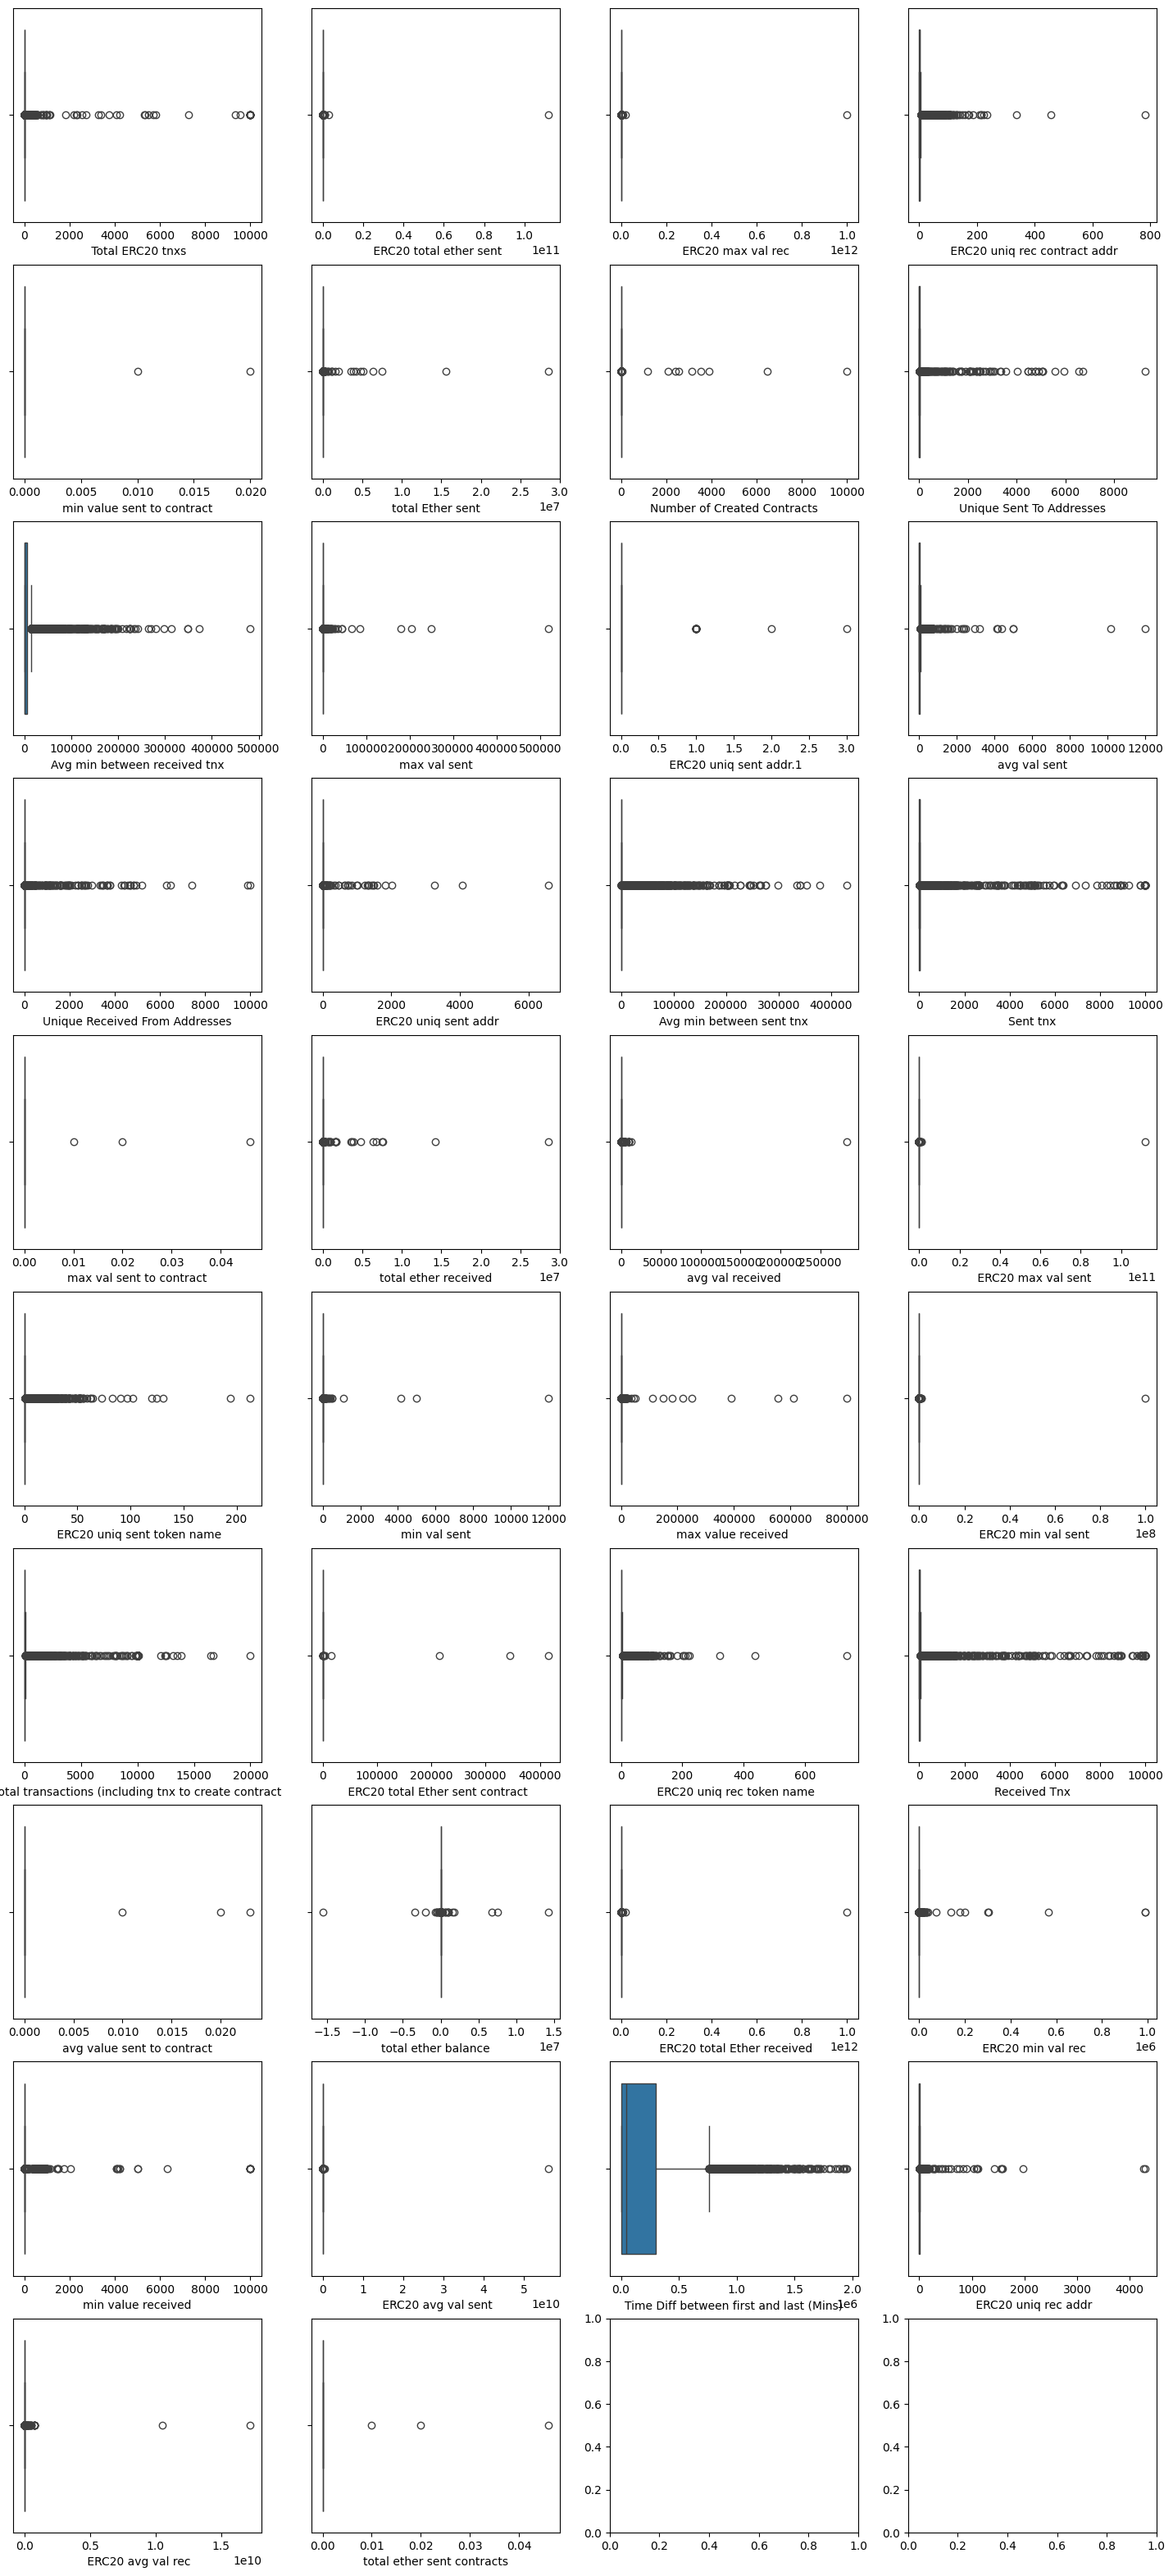

In [ ]:
fig, axes = plt.subplots(10, 4, figsize=(18, 40))
for i, feature in enumerate(num_feature_list):
    sns.boxplot(data=df, x=feature, ax=axes[i // 4][i % 4])

In [ ]:
print(cat_feature_list)

[' ERC20 most sent token type', ' ERC20_most_rec_token_type']


In [ ]:
print(df[cat_feature_list[0]].value_counts())
print('----------')
print(df[cat_feature_list[1]].value_counts())

 ERC20 most sent token type
0                               4388
                                1191
EOS                              138
OmiseGO                          136
Golem                            129
                                ... 
DAPSTOKEN                          1
Arcona Distribution Contract       1
HeroCoin                           1
Cindicator                         1
HackerGold                         1
Name: count, Length: 304, dtype: int64
----------
 ERC20_most_rec_token_type
0                        4388
OmiseGO                   870
Blockwell say NOTSAFU     779
DATAcoin                  358
Livepeer Token            205
                         ... 
Dropil                      1
CosmoCoin                   1
Petroleum                   1
Titanium BAR Token          1
LendConnect                 1
Name: count, Length: 466, dtype: int64


In [ ]:
for feature in cat_feature_list:
    df.loc[df[feature].isin([' ', '0']), feature] = 'None'

In [ ]:
print(len(df[num_feature_list].columns))
print(len(cat_feature_list))

38
2


In [ ]:
df[num_feature_list] = df[num_feature_list].fillna(df[num_feature_list].median())

In [ ]:
lower_quantile = 0.05
upper_quantile = 0.95

lower_bounds = df[num_feature_list].quantile(lower_quantile)
upper_bounds = df[num_feature_list].quantile(upper_quantile)

for feature in num_feature_list:
    df[feature] = df[feature].clip(lower=lower_bounds[feature], upper=upper_bounds[feature])


In [ ]:
df.drop(cat_feature_list, axis=1, inplace=True)

In [ ]:
print(len(df.columns))
print(len(df[num_feature_list].columns))

47
38


In [ ]:
df.drop(columns = ['Address'], inplace=True)

In [ ]:
df.drop(zero_feature_list, axis=1, inplace=True)


In [ ]:
df

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 uniq sent addr.1,ERC20 uniq rec contract addr,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 uniq sent token name,ERC20 uniq rec token name
0,0,844.260,1093.71,704785.630,242.8,89,0,25,35,0.000000,...,0.0,24.0,0.00,118474.46520,10402.063599,0.000000,37199.252000,5873.292433,6.0,23.9
1,0,12709.070,2958.44,974353.818,94.0,8,0,5,14,0.000000,...,0.0,7.0,0.00,365.00000,57.632615,2.260809,2.260809,2.260809,1.0,7.0
2,0,25325.002,2434.02,516729.300,2.0,10,0,10,2,0.113119,...,0.0,8.0,0.00,442.81984,65.189009,0.000000,0.000000,0.000000,0.0,8.0
3,0,10219.600,15785.09,397555.900,25.0,9,0,7,13,0.000000,...,0.0,11.0,0.00,11412.23068,1555.550174,4.000000,9029.230680,3804.076893,1.0,11.0
4,0,36.610,10707.77,382472.420,242.8,20,1,7,19,0.000000,...,0.0,24.0,0.00,90000.00000,4934.232147,0.000000,37199.252000,5873.292433,6.0,23.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,1,12635.100,631.39,58748.480,4.0,13,0,11,4,0.004082,...,0.0,2.0,0.00,1.33700,0.668500,0.000000,0.000000,0.000000,0.0,2.0
9837,1,0.000,0.00,0.000,0.0,0,0,0,0,0.000000,...,0.0,1.0,13.37,13.37000,13.370000,0.000000,0.000000,0.000000,0.0,1.0
9838,1,2499.440,2189.29,261601.880,67.0,43,0,25,35,0.001078,...,0.0,5.0,0.00,1500.00000,300.693901,0.000000,0.000000,0.000000,0.0,5.0
9839,1,0.000,0.00,0.000,0.0,1,0,1,0,0.500000,...,0.0,1.0,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,1.0


# Data Preparation

In [ ]:
y = df.iloc[:, 0]
X = df.iloc[:, 1:]
print(X.shape, y.shape)

(9823, 38) (9823,)


In [ ]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state = 0)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, shuffle=True, stratify=y_test_val, random_state = 0)
print(X_train.shape, X_val.shape, X_test.shape)

(6876, 38) (1473, 38) (1474, 38)


In [ ]:
sc = StandardScaler()
sc_train = sc.fit_transform(X_train)
sc_val = sc.transform(X_val)

In [ ]:
def plot_history(data_list, label_list, title, ylabel):
    ''' Plots a list of vectors.

    Parameters:
        data_list  : list of vectors containing the values to plot
        label_list : list of labels describing the data, one per vector
        title      : title of the plot
        ylabel     : label for the y axis
    '''
    epochs = range(1, len(data_list[0]) + 1)

    for data, label in zip(data_list, label_list):
        plt.plot(epochs, data, label=label)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()

    plt.show()

In [ ]:
## LOSS-ACC GRAPHS
import matplotlib.pyplot as plt

def plot_loss_accuracy(history, set_name):

    # Extracting the loss and accuracy values for plotting
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plotting training and validation -- loss and accuracy
    plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', f'{set_name} loss'],
             title=f'Training and {set_name.lower()} loss',
             ylabel='Loss')
    plot_history(data_list=[acc, val_acc],
             label_list=['Training acc.', f'{set_name} acc.'],
             title=f'Training and {set_name.lower()} accuracy',
             ylabel='Accuracy')


In [ ]:
print(np.unique(df['FLAG']))

[0 1]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

labels = np.unique(df['FLAG'])
def test_models_and_plot_confusion_matrix(y_true, y_prob):
    y_pred = (y_prob > 0.5).astype(int)
    plt.figure(figsize=(10, 7))
    ax = plt.subplot()

    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='g', ax=ax, cmap='Blues')
    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted labels', fontsize=20)
    ax.set_ylabel('True labels', fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=15)
    ax.yaxis.set_ticklabels(labels, fontsize=15, rotation=0)

    plt.show()

    print(classification_report(y_true, y_pred, digits=3))



In [ ]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

# Models

## Baseline Model

In [ ]:
mlp = models.Sequential()
mlp.add(layers.Input(shape=(sc_train.shape[1], )))

mlp.add(layers.Dense(sc_train.shape[1], activation='relu'))
mlp.add(layers.Dense(15, activation='relu'))
mlp.add(layers.Dense(5, activation='relu'))
mlp.add(layers.Dense(1, activation='sigmoid'))

mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 38)                1482      
                                                                 
 dense_1 (Dense)             (None, 15)                585       
                                                                 
 dense_2 (Dense)             (None, 5)                 80        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 2153 (8.41 KB)
Trainable params: 2153 (8.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = mlp.fit(sc_train, y_train, validation_data=(sc_val, y_val), epochs=20)

Epoch 1/20
215/215 [==============================] - 7s 10ms/step - loss: 0.3608 - accuracy: 0.8399 - val_loss: 0.2526 - val_accuracy: 0.8880
Epoch 2/20
215/215 [==============================] - 1s 5ms/step - loss: 0.2013 - accuracy: 0.9373 - val_loss: 0.1784 - val_accuracy: 0.9532
Epoch 3/20
215/215 [==============================] - 1s 3ms/step - loss: 0.1519 - accuracy: 0.9536 - val_loss: 0.1371 - val_accuracy: 0.9627
Epoch 4/20
215/215 [==============================] - 1s 3ms/step - loss: 0.1204 - accuracy: 0.9599 - val_loss: 0.1166 - val_accuracy: 0.9593
Epoch 5/20
215/215 [==============================] - 1s 3ms/step - loss: 0.1001 - accuracy: 0.9648 - val_loss: 0.1001 - val_accuracy: 0.9688
Epoch 6/20
215/215 [==============================] - 1s 2ms/step - loss: 0.0875 - accuracy: 0.9682 - val_loss: 0.0898 - val_accuracy: 0.9742
Epoch 7/20
215/215 [==============================] - 1s 3ms/step - loss: 0.0780 - accuracy: 0.9729 - val_loss: 0.0885 - val_accuracy: 0.9688
Epoch

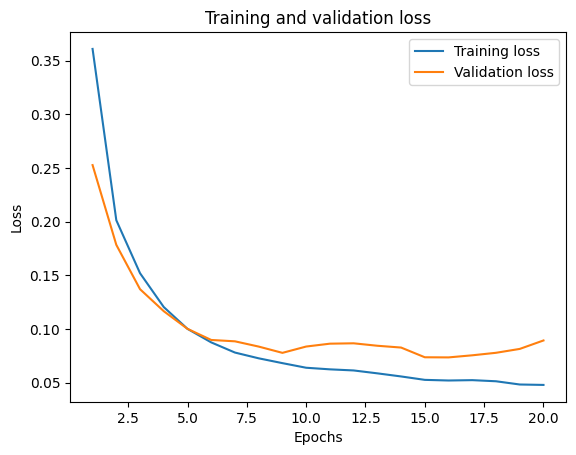

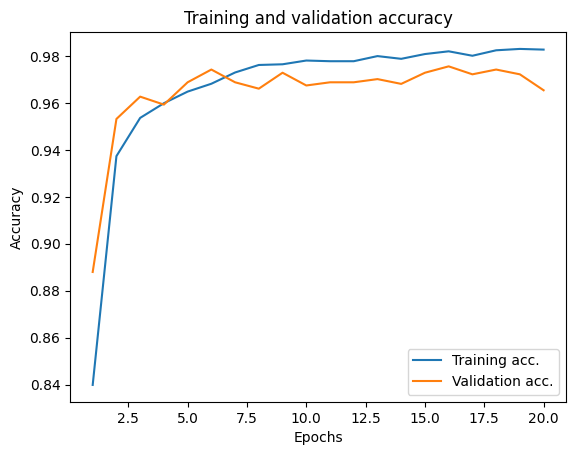

47/47 [==============================] - 0s 2ms/step


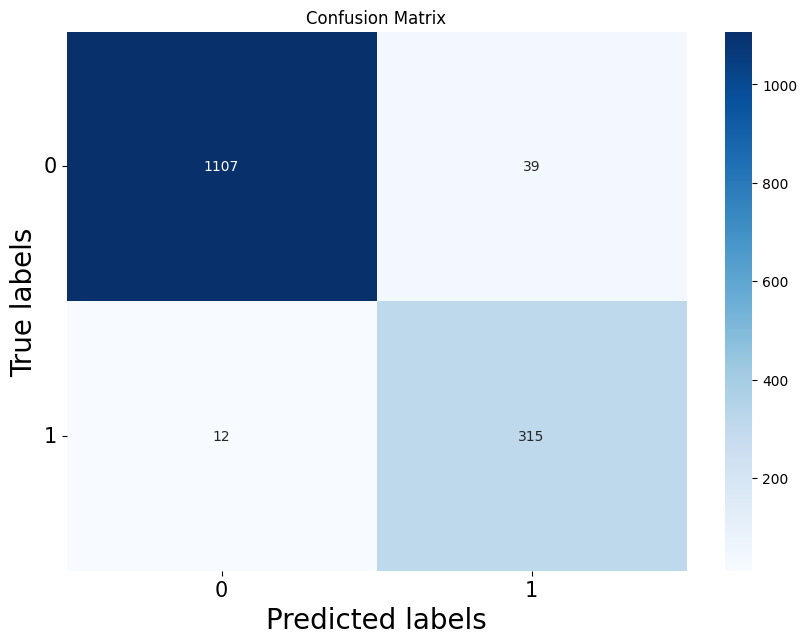

              precision    recall  f1-score   support

           0      0.989     0.966     0.977      1146
           1      0.890     0.963     0.925       327

    accuracy                          0.965      1473
   macro avg      0.940     0.965     0.951      1473
weighted avg      0.967     0.965     0.966      1473

47/47 [==============================] - 0s 2ms/step


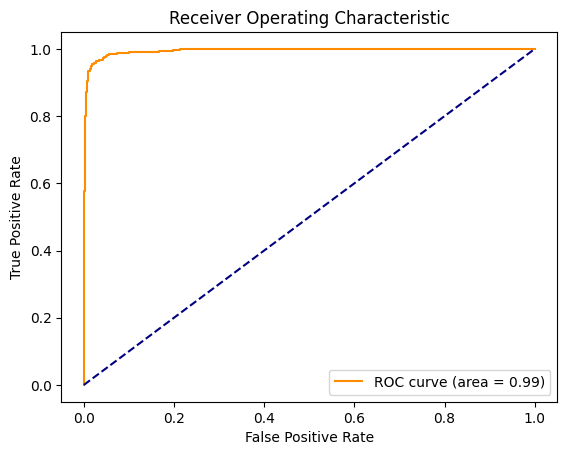

In [ ]:
plot_loss_accuracy(history)
test_models_and_plot_confusion_matrix(y_val, mlp.predict(sc_val))
plot_roc_curve(y_val,  mlp.predict(sc_val))

In [ ]:
y_val_prob = mlp.predict(sc_val)
roc_auc = roc_auc_score(y_val, y_val_prob)
print(f"The ROC-AUC Score on the validation set is: {roc_auc}")

47/47 [==============================] - 0s 2ms/step
The ROC-AUC Score on the validation set is: 0.9948658010044242


## SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
sc_X_train_smote = sc.fit_transform(X_train_smote)
print(f'Original dataset shape {Counter(y_train)}')
print(f'Resampled dataset with SMOTE shape {Counter(y_train_smote)}')

Original dataset shape Counter({0: 5351, 1: 1525})
Resampled dataset with SMOTE shape Counter({1: 5351, 0: 5351})


In [ ]:
mlp = models.Sequential()
mlp.add(layers.Input(shape=(sc_X_train_smote.shape[1], )))

mlp.add(layers.Dense(sc_X_train_smote.shape[1], activation='relu'))
mlp.add(layers.Dense(15, activation='relu'))
mlp.add(layers.Dense(5, activation='relu'))
mlp.add(layers.Dense(1, activation='sigmoid'))

mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mlp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 38)                1482      
                                                                 
 dense_5 (Dense)             (None, 15)                585       
                                                                 
 dense_6 (Dense)             (None, 5)                 80        
                                                                 
 dense_7 (Dense)             (None, 1)                 6         
                                                                 
Total params: 2153 (8.41 KB)
Trainable params: 2153 (8.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = mlp.fit(sc_X_train_smote, y_train_smote, validation_data=(sc_val, y_val), epochs=20)

Epoch 1/20
335/335 [==============================] - 2s 3ms/step - loss: 0.3916 - accuracy: 0.8169 - val_loss: 0.4553 - val_accuracy: 0.7705
Epoch 2/20
335/335 [==============================] - 1s 3ms/step - loss: 0.1660 - accuracy: 0.9464 - val_loss: 0.4031 - val_accuracy: 0.8031
Epoch 3/20
335/335 [==============================] - 1s 3ms/step - loss: 0.1075 - accuracy: 0.9639 - val_loss: 0.3152 - val_accuracy: 0.8337
Epoch 4/20
335/335 [==============================] - 1s 3ms/step - loss: 0.0864 - accuracy: 0.9716 - val_loss: 0.3416 - val_accuracy: 0.8248
Epoch 5/20
335/335 [==============================] - 1s 2ms/step - loss: 0.0761 - accuracy: 0.9745 - val_loss: 0.2723 - val_accuracy: 0.9138
Epoch 6/20
335/335 [==============================] - 1s 2ms/step - loss: 0.0679 - accuracy: 0.9771 - val_loss: 0.3058 - val_accuracy: 0.8615
Epoch 7/20
335/335 [==============================] - 1s 4ms/step - loss: 0.0624 - accuracy: 0.9779 - val_loss: 0.2672 - val_accuracy: 0.9219
Epoch 

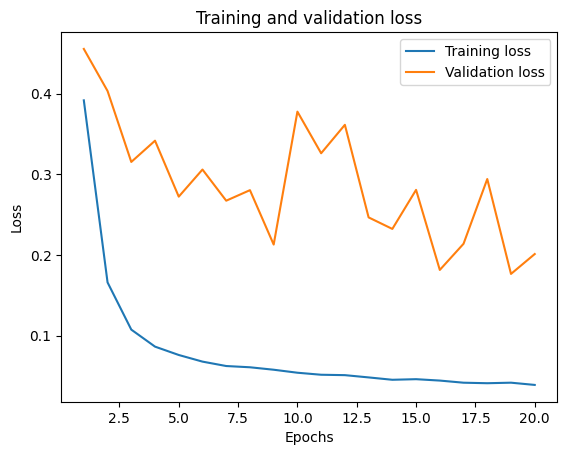

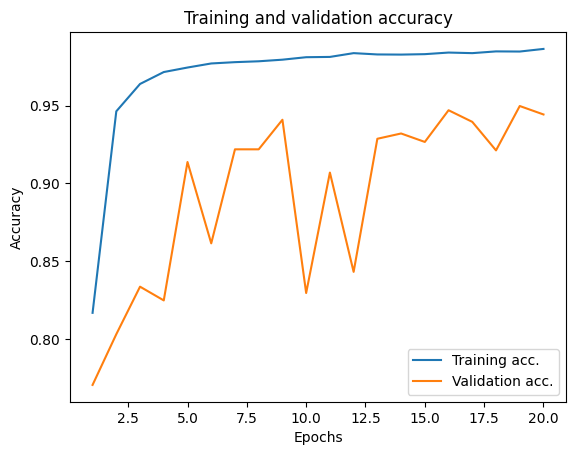

47/47 [==============================] - 0s 2ms/step


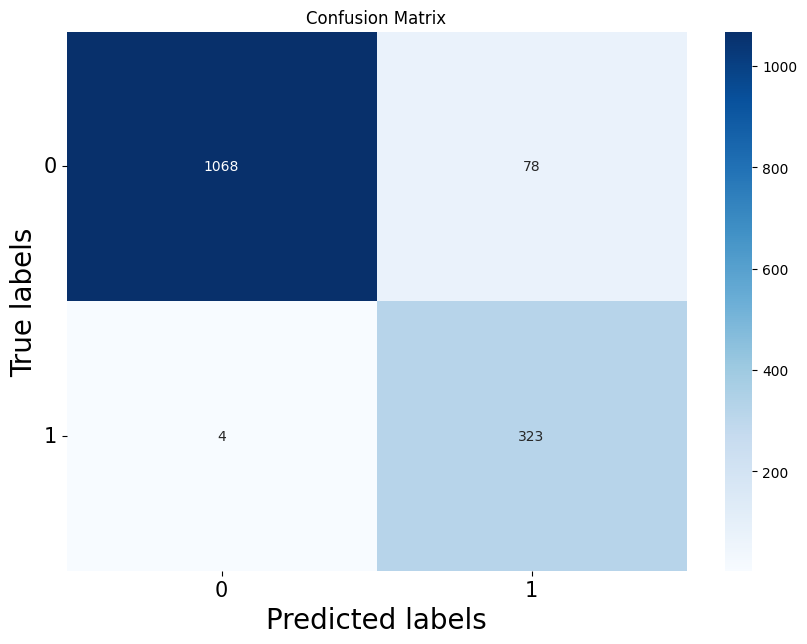

              precision    recall  f1-score   support

           0      0.996     0.932     0.963      1146
           1      0.805     0.988     0.887       327

    accuracy                          0.944      1473
   macro avg      0.901     0.960     0.925      1473
weighted avg      0.954     0.944     0.946      1473

47/47 [==============================] - 0s 2ms/step


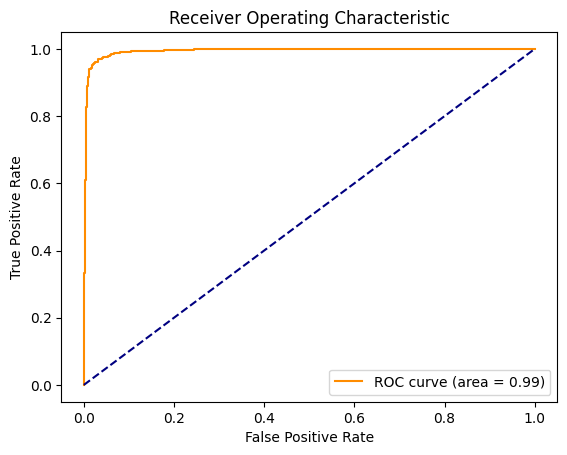

In [ ]:
plot_loss_accuracy(history)
test_models_and_plot_confusion_matrix(y_val, mlp.predict(sc_val))
plot_roc_curve(y_val,  mlp.predict(sc_val))

In [ ]:
y_val_prob = mlp.predict(sc_val)
roc_auc = roc_auc_score(y_val, y_val_prob)
print(f"The ROC-AUC Score on the validation set is: {roc_auc}")

47/47 [==============================] - 0s 2ms/step
The ROC-AUC Score on the validation set is: 0.9936222787944773


## ADA

In [ ]:
ada = ADASYN(random_state=42)
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)
sc_X_train_ada = sc.fit_transform(X_train_ada)

In [ ]:
mlp = models.Sequential()
mlp.add(layers.Input(shape=(sc_X_train_ada.shape[1], )))

mlp.add(layers.Dense(sc_X_train_ada.shape[1], activation='relu'))
mlp.add(layers.Dense(15, activation='relu'))
mlp.add(layers.Dense(5, activation='relu'))
mlp.add(layers.Dense(1, activation='sigmoid'))

mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mlp.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 38)                1482      
                                                                 
 dense_9 (Dense)             (None, 15)                585       
                                                                 
 dense_10 (Dense)            (None, 5)                 80        
                                                                 
 dense_11 (Dense)            (None, 1)                 6         
                                                                 
Total params: 2153 (8.41 KB)
Trainable params: 2153 (8.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = mlp.fit(sc_X_train_ada, y_train_ada, validation_data=(sc_val, y_val), epochs=20)

Epoch 1/20
339/339 [==============================] - 2s 3ms/step - loss: 0.3286 - accuracy: 0.8685 - val_loss: 0.5721 - val_accuracy: 0.7155
Epoch 2/20
339/339 [==============================] - 1s 2ms/step - loss: 0.1634 - accuracy: 0.9483 - val_loss: 0.5437 - val_accuracy: 0.7352
Epoch 3/20
339/339 [==============================] - 1s 3ms/step - loss: 0.1184 - accuracy: 0.9601 - val_loss: 0.5463 - val_accuracy: 0.7644
Epoch 4/20
339/339 [==============================] - 1s 2ms/step - loss: 0.0974 - accuracy: 0.9664 - val_loss: 0.4588 - val_accuracy: 0.7916
Epoch 5/20
339/339 [==============================] - 1s 2ms/step - loss: 0.0863 - accuracy: 0.9697 - val_loss: 0.4739 - val_accuracy: 0.7814
Epoch 6/20
339/339 [==============================] - 1s 3ms/step - loss: 0.0796 - accuracy: 0.9719 - val_loss: 0.3200 - val_accuracy: 0.8948
Epoch 7/20
339/339 [==============================] - 1s 3ms/step - loss: 0.0741 - accuracy: 0.9724 - val_loss: 0.3318 - val_accuracy: 0.8982
Epoch 

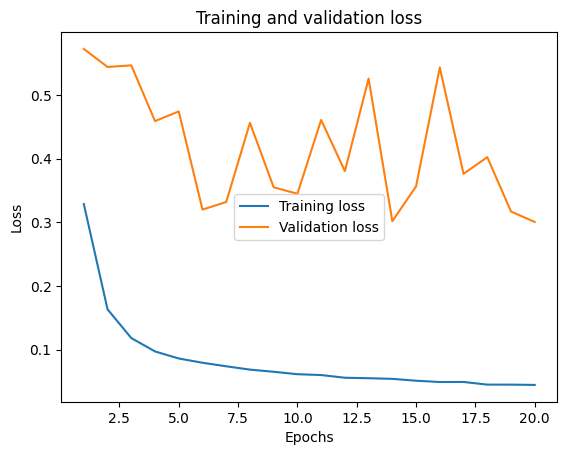

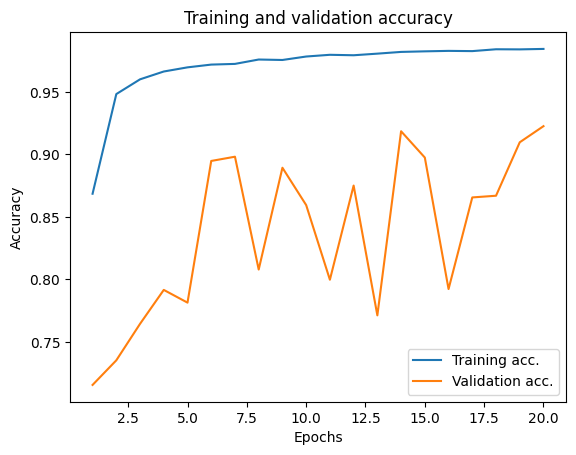

47/47 [==============================] - 0s 2ms/step


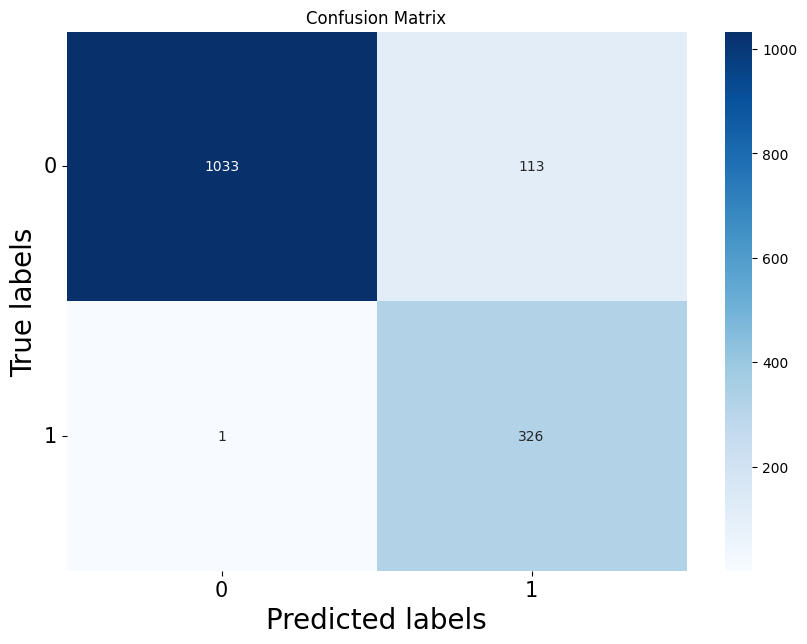

              precision    recall  f1-score   support

           0      0.999     0.901     0.948      1146
           1      0.743     0.997     0.851       327

    accuracy                          0.923      1473
   macro avg      0.871     0.949     0.899      1473
weighted avg      0.942     0.923     0.926      1473

47/47 [==============================] - 0s 1ms/step


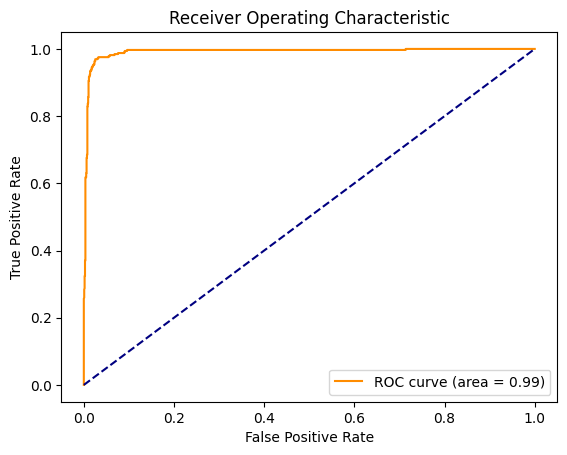

In [ ]:
plot_loss_accuracy(history)
test_models_and_plot_confusion_matrix(y_val, mlp.predict(sc_val))
plot_roc_curve(y_val,  mlp.predict(sc_val))

In [ ]:
y_val_prob = mlp.predict(sc_val)
roc_auc = roc_auc_score(y_val, y_val_prob)
print(f"The ROC-AUC Score on the validation set is: {roc_auc}")

47/47 [==============================] - 0s 2ms/step
The ROC-AUC Score on the validation set is: 0.99150615623549


## Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
sc_X_train_rus = sc.fit_transform(X_train_rus)

In [ ]:
mlp = models.Sequential()
mlp.add(layers.Input(shape=(sc_X_train_rus.shape[1], )))

mlp.add(layers.Dense(sc_X_train_rus.shape[1], activation='relu'))
mlp.add(layers.Dense(15, activation='relu'))
mlp.add(layers.Dense(5, activation='relu'))
mlp.add(layers.Dense(1, activation='sigmoid'))

mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mlp.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 38)                1482      
                                                                 
 dense_13 (Dense)            (None, 15)                585       
                                                                 
 dense_14 (Dense)            (None, 5)                 80        
                                                                 
 dense_15 (Dense)            (None, 1)                 6         
                                                                 
Total params: 2153 (8.41 KB)
Trainable params: 2153 (8.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = mlp.fit(sc_X_train_rus, y_train_rus, validation_data=(sc_val, y_val), epochs=20)

Epoch 1/20
96/96 [==============================] - 2s 5ms/step - loss: 0.5044 - accuracy: 0.7603 - val_loss: 0.5308 - val_accuracy: 0.6884
Epoch 2/20
96/96 [==============================] - 0s 3ms/step - loss: 0.3229 - accuracy: 0.8521 - val_loss: 0.5772 - val_accuracy: 0.7013
Epoch 3/20
96/96 [==============================] - 0s 3ms/step - loss: 0.2565 - accuracy: 0.8944 - val_loss: 0.4608 - val_accuracy: 0.7508
Epoch 4/20
96/96 [==============================] - 0s 3ms/step - loss: 0.2168 - accuracy: 0.9213 - val_loss: 0.4090 - val_accuracy: 0.7746
Epoch 5/20
96/96 [==============================] - 0s 3ms/step - loss: 0.1866 - accuracy: 0.9367 - val_loss: 0.4755 - val_accuracy: 0.7576
Epoch 6/20
96/96 [==============================] - 0s 3ms/step - loss: 0.1616 - accuracy: 0.9531 - val_loss: 0.4327 - val_accuracy: 0.7712
Epoch 7/20
96/96 [==============================] - 0s 4ms/step - loss: 0.1418 - accuracy: 0.9557 - val_loss: 0.4540 - val_accuracy: 0.7658
Epoch 8/20
96/96 [==

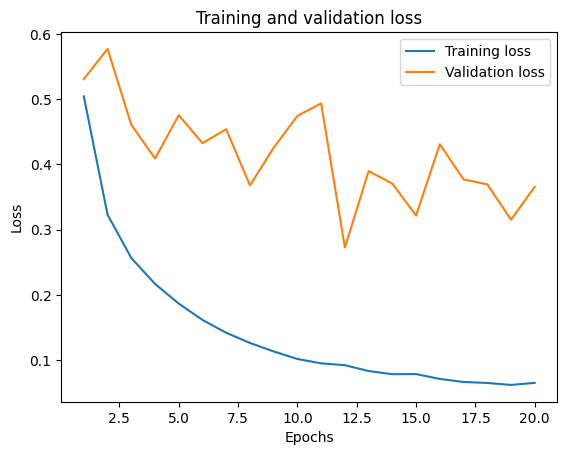

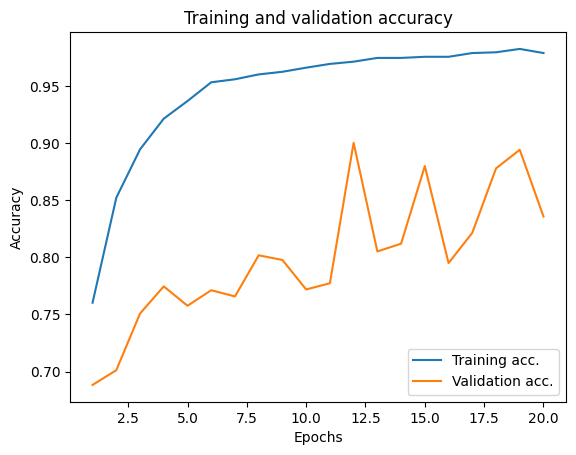

47/47 [==============================] - 0s 2ms/step


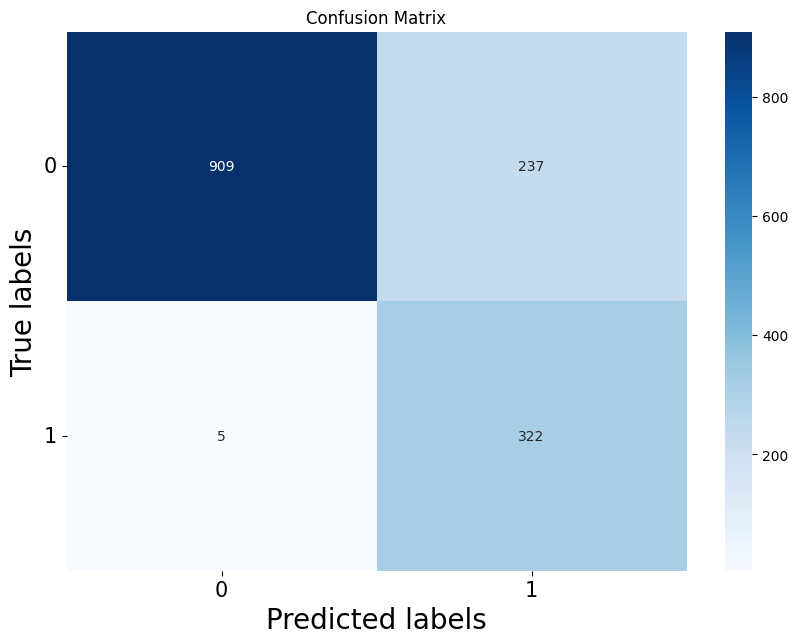

              precision    recall  f1-score   support

           0      0.995     0.793     0.883      1146
           1      0.576     0.985     0.727       327

    accuracy                          0.836      1473
   macro avg      0.785     0.889     0.805      1473
weighted avg      0.902     0.836     0.848      1473

47/47 [==============================] - 0s 1ms/step


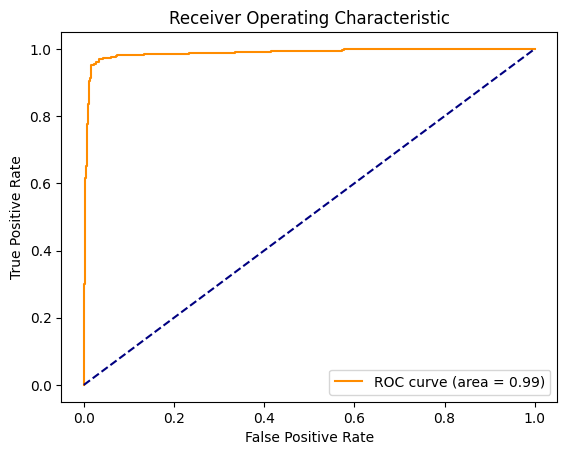

In [ ]:
plot_loss_accuracy(history)
test_models_and_plot_confusion_matrix(y_val, mlp.predict(sc_val))
plot_roc_curve(y_val,  mlp.predict(sc_val))

In [ ]:
y_val_prob = mlp.predict(sc_val)
roc_auc = roc_auc_score(y_val, y_val_prob)
print(f"The ROC-AUC Score on the validation set is: {roc_auc}")

47/47 [==============================] - 0s 2ms/step
The ROC-AUC Score on the validation set is: 0.9876101424446686


# Hyperparameter Tuning

In [ ]:
# combine train and validation datasets for cross validation later?
X_full = np.concatenate((X_train, X_val))
y_full = np.concatenate((y_train, y_val))
sc_full = sc.fit_transform(X_full)
sc_test = sc.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [ ]:
def build_model(hp):
    model = models.Sequential([
        layers.InputLayer(input_shape=(sc_full.shape[1],)),
        layers.Dense(
            units=hp.Int('units_first', min_value=32, max_value=512, step=32, default=38),
            activation=hp.Choice('activation_first', values=['relu', 'tanh', 'sigmoid'])
        ),
        layers.Dense(
            units=hp.Int('units_second', min_value=16, max_value=256, step=16, default=15),
            activation=hp.Choice('activation_second', values=['relu', 'tanh', 'sigmoid'])
        ),
        layers.Dense(
            units=hp.Int('units_third', min_value=8, max_value=128, step=8, default=5),
            activation=hp.Choice('activation_third', values=['relu', 'tanh', 'sigmoid'])
        ),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1
for train_index, test_index in kf.split(sc_full):

    tuner = RandomSearch(
        build_model,
        objective='val_accuracy',
        max_trials=10,
        executions_per_trial=1,
        directory='ktuner_output',  # Consider adding fold info to the directory name
        project_name=f'mlp_tuning_fold_{fold_no}'
    )
    tuner.search(
        x=sc_full[train_index],
        y=y_full[train_index],
        epochs=20,
        validation_data=(sc_full[test_index], y_full[test_index]))
    fold_no += 1


Trial 10 Complete [00h 00m 22s]
val_accuracy: 0.971839427947998

Best val_accuracy So Far: 0.974835216999054
Total elapsed time: 00h 04m 18s


In [ ]:
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

{'units_first': 416, 'activation_first': 'relu', 'units_second': 80, 'activation_second': 'sigmoid', 'units_third': 112, 'activation_third': 'sigmoid', 'learning_rate': 0.0009124105694925094}


In [ ]:
final_model = build_model(best_hyperparameters)

In [ ]:
history = final_model.fit(sc_full, y_full, validation_data=(sc_test, y_test), epochs=20)


Epoch 1/20
261/261 [==============================] - 2s 4ms/step - loss: 0.2636 - accuracy: 0.8981 - val_loss: 0.1573 - val_accuracy: 0.9573
Epoch 2/20
261/261 [==============================] - 1s 5ms/step - loss: 0.1281 - accuracy: 0.9593 - val_loss: 0.1205 - val_accuracy: 0.9620
Epoch 3/20
261/261 [==============================] - 1s 6ms/step - loss: 0.1006 - accuracy: 0.9674 - val_loss: 0.0995 - val_accuracy: 0.9674
Epoch 4/20
261/261 [==============================] - 2s 6ms/step - loss: 0.0899 - accuracy: 0.9703 - val_loss: 0.1114 - val_accuracy: 0.9640
Epoch 5/20
261/261 [==============================] - 1s 5ms/step - loss: 0.0824 - accuracy: 0.9719 - val_loss: 0.0893 - val_accuracy: 0.9661
Epoch 6/20
261/261 [==============================] - 1s 4ms/step - loss: 0.0742 - accuracy: 0.9746 - val_loss: 0.0855 - val_accuracy: 0.9722
Epoch 7/20
261/261 [==============================] - 1s 3ms/step - loss: 0.0692 - accuracy: 0.9758 - val_loss: 0.0925 - val_accuracy: 0.9701
Epoch 

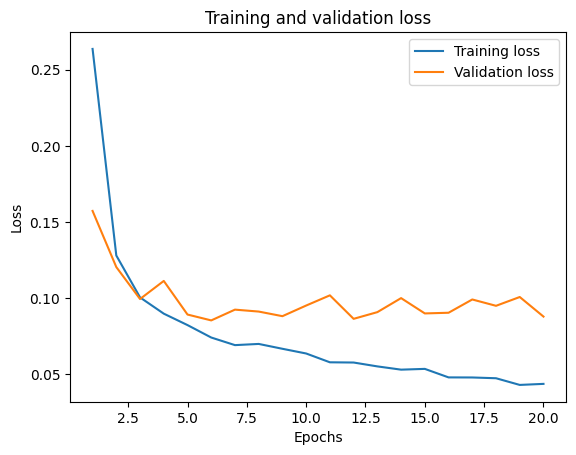

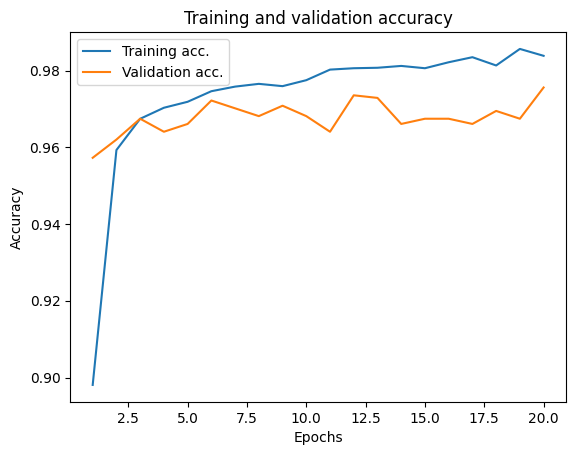

47/47 [==============================] - 0s 2ms/step


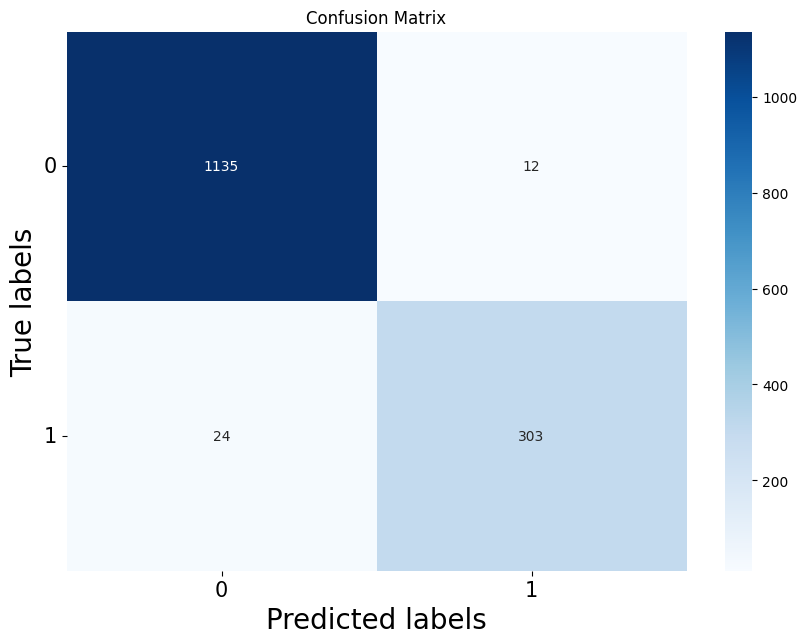

              precision    recall  f1-score   support

           0      0.979     0.990     0.984      1147
           1      0.962     0.927     0.944       327

    accuracy                          0.976      1474
   macro avg      0.971     0.958     0.964      1474
weighted avg      0.975     0.976     0.975      1474

47/47 [==============================] - 0s 2ms/step


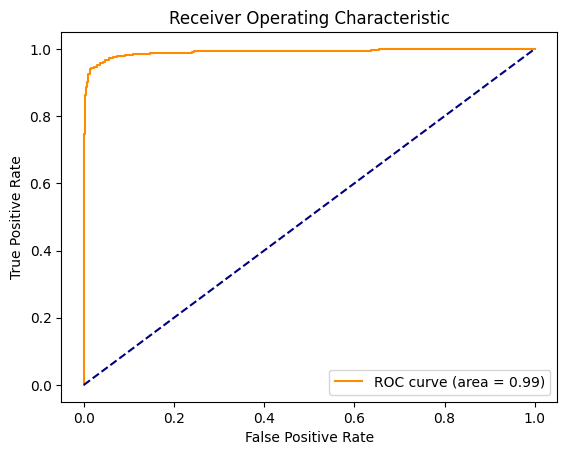

In [ ]:
plot_loss_accuracy(history, set_name='Test')
test_models_and_plot_confusion_matrix(y_test, final_model.predict(sc_test))
plot_roc_curve(y_test,  final_model.predict(sc_test))

In [ ]:
y_test_prob = final_model.predict(sc_test)
roc_auc = roc_auc_score(y_test, y_test_prob)
print(f"The ROC-AUC Score on the validation set is: {roc_auc}")

47/47 [==============================] - 0s 2ms/step
The ROC-AUC Score on the validation set is: 0.9909216704126439


In [ ]:
training_times = []
for i in range(100):
    start_time = time.time()
    final_model.fit(sc_full, y_full, validation_data=(sc_test, y_test), epochs=20)
    end_time = time.time()
    training_times.append(end_time - start_time)
average_training_time = np.average(training_times)
print("Average Training Time: {:.2f} seconds".format(average_training_time))

Epoch 1/20
261/261 [==============================] - 1s 4ms/step - loss: 0.0427 - accuracy: 0.9845 - val_loss: 0.0955 - val_accuracy: 0.9695
Epoch 2/20
261/261 [==============================] - 1s 3ms/step - loss: 0.0400 - accuracy: 0.9859 - val_loss: 0.1000 - val_accuracy: 0.9701
Epoch 3/20
261/261 [==============================] - 1s 3ms/step - loss: 0.0386 - accuracy: 0.9855 - val_loss: 0.1000 - val_accuracy: 0.9715
Epoch 4/20
261/261 [==============================] - 1s 3ms/step - loss: 0.0390 - accuracy: 0.9859 - val_loss: 0.1098 - val_accuracy: 0.9668
Epoch 5/20
261/261 [==============================] - 1s 3ms/step - loss: 0.0341 - accuracy: 0.9881 - val_loss: 0.1150 - val_accuracy: 0.9661
Epoch 6/20
261/261 [==============================] - 1s 3ms/step - loss: 0.0388 - accuracy: 0.9860 - val_loss: 0.0983 - val_accuracy: 0.9715
Epoch 7/20
261/261 [==============================] - 1s 3ms/step - loss: 0.0344 - accuracy: 0.9885 - val_loss: 0.1047 - val_accuracy: 0.9722
Epoch 

In [ ]:
print("Average Training Time: {:.2f} seconds".format(average_training_time))

Average Training Time: 34.32 seconds


In [ ]:
test_times = []
for i in range(100):
    start_time = time.time()
    final_model.predict(sc_test)
    end_time = time.time()
    test_times.append(end_time - start_time)
average_test_time = np.average(test_times)
print("Inference speed: {:.2f} seconds".format(average_training_time))

47/47 [==============================] - 0s 2ms/step
Inference speed: 34.32 seconds


In [ ]:
print("Inference speed: {:.2f} seconds".format(average_training_time))

Inference speed: 34.32 seconds


# Compare train/test performance

In [ ]:
mlp = models.Sequential()
mlp.add(layers.Input(shape=(sc_train.shape[1], )))

mlp.add(layers.Dense(416, activation='relu'))
mlp.add(layers.Dense(80, activation='sigmoid'))
mlp.add(layers.Dense(112, activation='sigmoid'))
mlp.add(layers.Dense(1, activation='sigmoid'))

mlp.compile(optimizer=Adam(learning_rate= 0.0009124105694925094), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = mlp.fit(sc_full, y_full, validation_data=(sc_test, y_test), epochs=20)

Epoch 1/20
261/261 [==============================] - 2s 3ms/step - loss: 0.2707 - accuracy: 0.8910 - val_loss: 0.1549 - val_accuracy: 0.9613
Epoch 2/20
261/261 [==============================] - 1s 2ms/step - loss: 0.1283 - accuracy: 0.9610 - val_loss: 0.1343 - val_accuracy: 0.9640
Epoch 3/20
261/261 [==============================] - 1s 2ms/step - loss: 0.0975 - accuracy: 0.9675 - val_loss: 0.1119 - val_accuracy: 0.9634
Epoch 4/20
261/261 [==============================] - 1s 2ms/step - loss: 0.0880 - accuracy: 0.9719 - val_loss: 0.0964 - val_accuracy: 0.9668
Epoch 5/20
261/261 [==============================] - 1s 2ms/step - loss: 0.0802 - accuracy: 0.9731 - val_loss: 0.0919 - val_accuracy: 0.9647
Epoch 6/20
261/261 [==============================] - 1s 2ms/step - loss: 0.0736 - accuracy: 0.9744 - val_loss: 0.1014 - val_accuracy: 0.9668
Epoch 7/20
261/261 [==============================] - 1s 2ms/step - loss: 0.0703 - accuracy: 0.9762 - val_loss: 0.1001 - val_accuracy: 0.9668
Epoch 

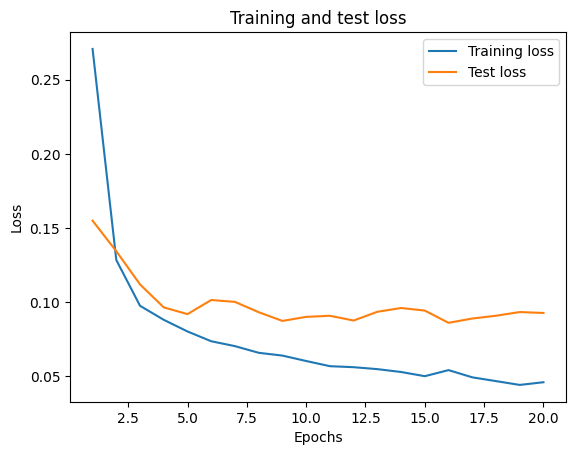

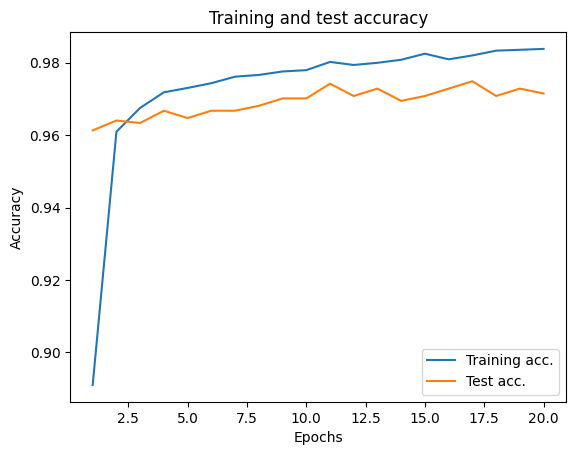

In [ ]:
plot_loss_accuracy(history, set_name='Test')

261/261 [==============================] - 0s 1ms/step


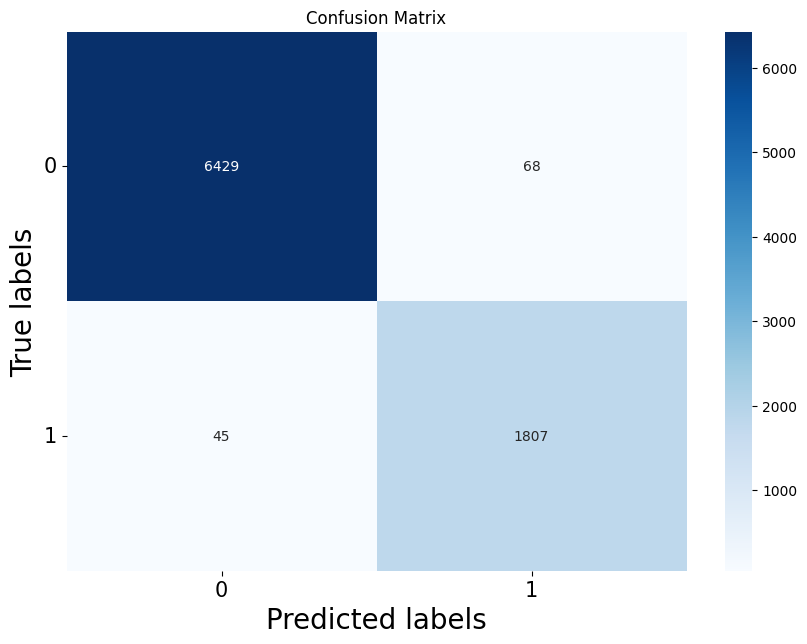

              precision    recall  f1-score   support

           0      0.993     0.990     0.991      6497
           1      0.964     0.976     0.970      1852

    accuracy                          0.986      8349
   macro avg      0.978     0.983     0.980      8349
weighted avg      0.987     0.986     0.986      8349



In [ ]:
test_models_and_plot_confusion_matrix(y_full, mlp.predict(sc_full))

47/47 [==============================] - 0s 1ms/step


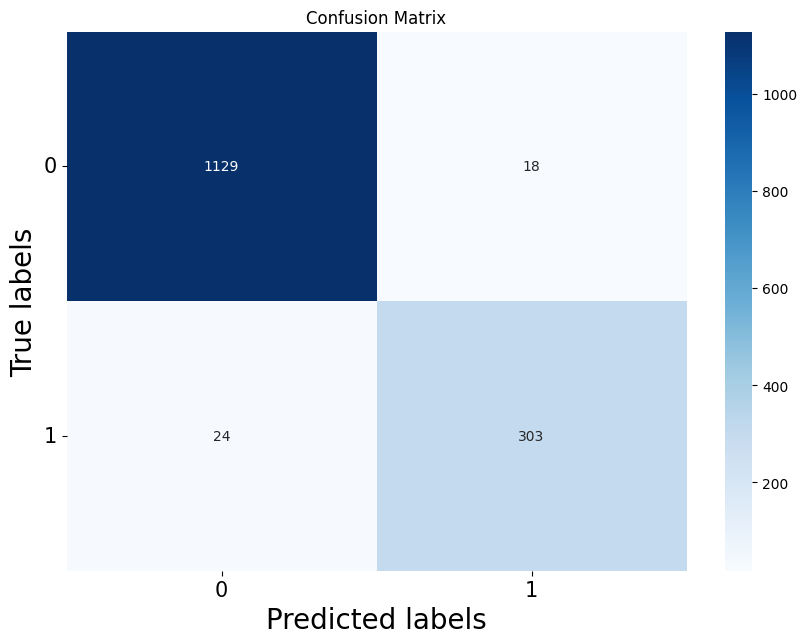

              precision    recall  f1-score   support

           0      0.979     0.984     0.982      1147
           1      0.944     0.927     0.935       327

    accuracy                          0.972      1474
   macro avg      0.962     0.955     0.958      1474
weighted avg      0.971     0.972     0.971      1474



In [ ]:
test_models_and_plot_confusion_matrix(y_test, mlp.predict(sc_test))

261/261 [==============================] - 0s 1ms/step


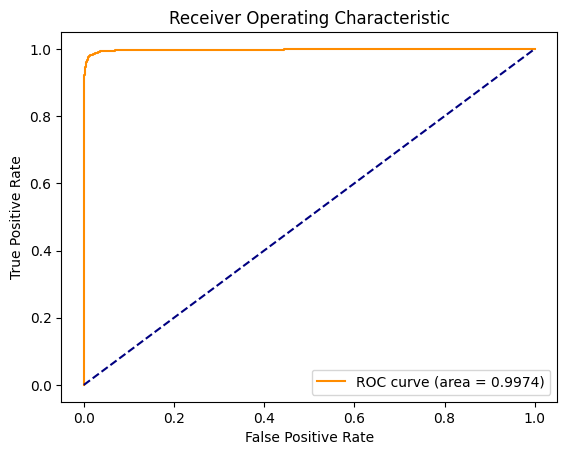

In [ ]:
plot_roc_curve(y_full,  mlp.predict(sc_full))

47/47 [==============================] - 0s 1ms/step


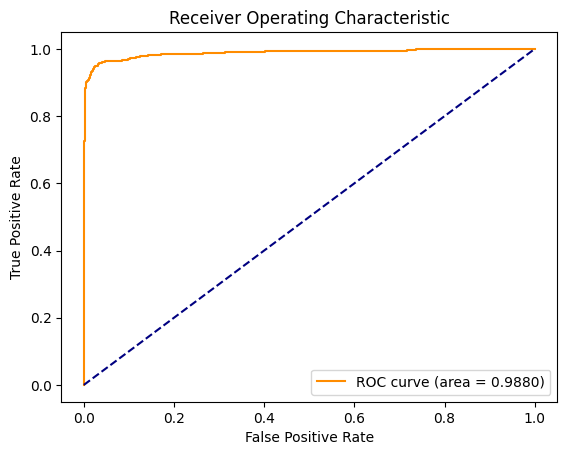

In [ ]:
plot_roc_curve(y_test,  mlp.predict(sc_test))

In [ ]:
mlp.save('/content/drive/MyDrive/Thesis Code/tuned_mlp.keras')

In [ ]:
import keras
my_model = keras.models.load_model('/content/drive/MyDrive/Thesis Code/tuned_mlp.keras')